In [1]:
using Iterators
using Pipe
using Compat

macro printval(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr," = ", $ee)))
end

macro pz(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr,"\t\t",typeof($ee), "\t", size($ee))))
end

In [2]:
using RecursiveAutoencoders
using UnfoldingRAE
using Base.Collections
using WordEmbeddings

In [3]:
LL,word_indexes, indexed_words =  load_embeddings("word_emb_data/embeddings-test.txt");
LL[:]./=maximum(abs(LL[:]))
size(LL) |> println
word_indexes |> typeof |> println
indexed_words |> typeof |> println

@pz LL

(50,14)
Dict{ASCIIString,Int64}
Array{ASCIIString,1}
LL		Array{Float32,2}	(50,14)


In [4]:
training_trees = open("training_sents.jsz","r") do fs
    deserialize(fs)
end;
@pz training_trees

training_trees		Array{Any,1}	(3914,)


In [5]:
training_trees = training_trees[1:10];

In [6]:
function test()
    rr = RAE(LL,word_indexes,indexed_words);

    a=fold(rr,("killer", "cows"))
    typeof(a) |> println
    b=unfold(rr,a);
    @assert b[1].parent==b[2].parent


    a=fold(rr,("the",("killer", "cows")))
    b=unfold(rr,a);
    @assert b[1].parent==b[2].parent.parent==b[3].parent.parent
end
test()


FoldData


In [7]:
function test()
    rr = RAE(LL,word_indexes,indexed_words);
    a=fold(rr,("the",("bad",("killer", "cows"))))
    b=unfold(rr,a);
    @pz rr.W_d
    δd,ΔW_d, Δb_d = UBPTS(rr, b)
    println("-"^54)
    @pz rr.W_d
    @pz ΔW_d
    @pz rr.b_d
    @pz Δb_d

    ΔW_e,Δb_e = UBPTS(rr, a, δd)
    println("+"^54)
    @pz rr.W_e
    @pz ΔW_e
    @pz rr.b_e
    @pz Δb_e

end
test()

rr.W_d		Array{Float32,2}	(100,50)
------------------------------------------------------
rr.W_d		Array{Float32,2}	(100,50)
ΔW_d		Array{Float32,2}	(100,50)
rr.b_d		Array{Float32,1}	(100,)
Δb_d		Array{Float32,1}	(100,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++
rr.W_e		Array{Float32,2}	(50,100)
ΔW_e		Array{Float32,2}	(50,100)
rr.b_e		Array{Float32,1}	(50,)
Δb_e		Array{Float32,1}	(50,)


In [8]:
using ArrayViews

In [11]:
Profile.init(10000,0.0000001)
@profile(test(rae_outer);)
Profile.print()

2  ./inference.jl; anonymous; line: 0
1  loading.jl; include_string; line: 97
 1 profile.jl; anonymous; line: 14
  1 In[10]; test; line: 5
   1 abstractarray.jl; vcat; line: 554
31 task.jl; anonymous; line: 340
 30 ...4/IJulia/src/IJulia.jl; eventloop; line: 123
  29 ...rc/execute_request.jl; execute_request_0x535c5df2; line: 157
   28 loading.jl; include_string; line: 97
    27 profile.jl; anonymous; line: 14
     26 In[10]; test; line: 5
      26 abstractarray.jl; vcat; line: 554
   1  profile.jl; anonymous; line: 14
    1 In[10]; test; line: 5
     1 abstractarray.jl; vcat; line: 554
  1  loading.jl; include_string; line: 97


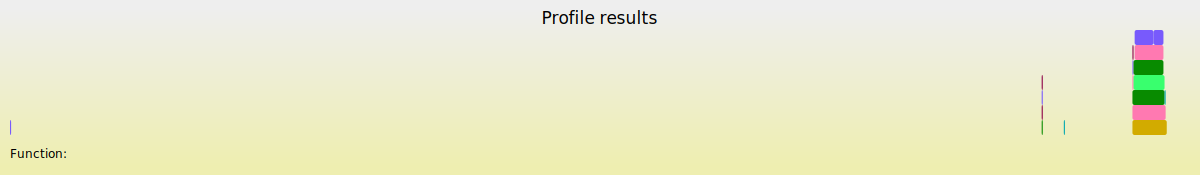

In [12]:
using ProfileView
ProfileView.view()

In [ ]:
elapsed time: 0.000270554 seconds (1220240 bytes allocated)

In [ ]:
elapsed time: 0.000104285 seconds (366584 bytes allocated)  #Reshape
elapsed time: 9.2663e-5 seconds (366392 bytes allocated)    #No Reshape

In [11]:
# tests

function analytic_grad(rae::RAE, tree::@compat Tuple{Any,Any})
    (Δs, err)=loss_and_loss_grad(rae, tree)
    tuple(Δs...)
end
 
function numeric_grad(rae::RAE, tree::@compat Tuple{Any,Any}, ϵ=10.0^-4)
    rae_inner = deepcopy(rae)
    θ = pack(rae_inner)
        Δθ = zeros(size(θ))
    for ii in 1:length(θ)
        ϵᵢ = zeros(size(θ))
        ϵᵢ[ii]=ϵ
        θⁱ⁺ = θ + ϵᵢ
        θⁱ⁻ = θ - ϵᵢ
        
        unpack!(rae_inner,θⁱ⁺)
        Jⁱ⁺ = loss(rae_inner, tree)
        
        unpack!(rae_inner,θⁱ⁻)
        Jⁱ⁻=loss(rae_inner, tree)
        Δθ[ii] = (Jⁱ⁺-Jⁱ⁻)/(2.0*ϵ)
    end
    unpack!(rae_inner,Δθ)
    
    (rae_inner.W_e, rae_inner.b_e, rae_inner.W_d, rae_inner.b_d)
   
end

LoadError: @compat not defined
while loading In[11], in expression starting on line 7

In [ ]:
#eg_tree = training_trees[2]
rae_outer = RAE(LL,word_indexes,indexed_words);
#aW_e, ab_e, aW_d, ab_d = analytic_grad(rae_outer, eg_tree);
#nW_e, nb_e, nW_d, nb_d = numeric_grad(rae_outer, eg_tree, 10.0^-7);


In [ ]:
ngs = pack(nW_e, nb_e, nW_d, nb_d)
ags = pack(aW_e, ab_e, aW_d, ab_d)

@printval mean(abs(ngs-ags))
@printval median(abs(ngs-ags))
@printval maximum(abs(ngs-ags))
@printval norm(ngs-ags)
println("-"^54)


for (ng,ag) in zip(ngs, ags)
    println(ng,"\t", ag, "\t", abs(ng-ag))
end




In [ ]:
using ForwardDiff

function f(θ)
    rae_inner = RAE(rae_outer.L, rae_outer.word_index, rae_outer.indexed_words,
        similar(rae_outer.W_e),similar(rae_outer.b_e),similar(rae_outer.W_d),similar(rae_outer.b_d))
    unpack!(rae_inner,θ)
    loss(rae_inner, training_trees[2])
end

# Using forwarddiff_jacobian
g = forwarddiff_gradient(f, Float64, fadtype=:dual, n=length(pack(rae_outer)))


In [ ]:
θ = pack(rae_outer)
dg = g(θ)

In [ ]:
ag = pack(analytic_grad(rae_outer, training_trees[2])...)

In [ ]:
maximum(abs(dg.-ag))


In [ ]:
map(t->Vector{t}, [Number, Float16])

In [ ]:
Union(subtypes(Number)...)

In [ ]:
Dual